In [7]:
%autosave 15
%matplotlib inline

import numpy as np
import scipy as sp
import math
import random

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

Autosaving every 15 seconds


In [8]:
def get_data():
    fin = open('chips.txt', 'r')
    classes = dict()
    data = list()
    
    for x, y, z in [map(float, x.split(',')) for x in fin.readlines()]:
        data.append((x, y))
        classes[(x, y)] = z
    
    fin.close()
    return (data, classes)


data, classes = get_data()

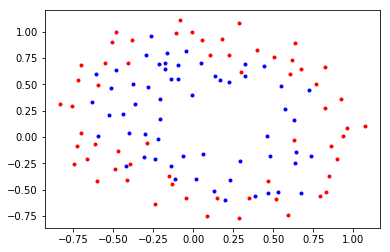

In [12]:
def printAllPoints():
    red = [[], []]
    blue = [[], []]
    for (x, y) in data:
        if (classes[(x, y)] == 0):
            red[0].append(x)
            red[1].append(y)
        else:
            blue[0].append(x)
            blue[1].append(y)
    plt.plot(red[0], red[1], 'r.', blue[0], blue[1], 'b.')
    

printAllPoints()

In [17]:
def minkowskiDistance(x, y, p):
    res = 0
    for i in range(len(x)):
        res += abs(x[i] - y[i]) ** p
    return res ** (1 / p)


metrics = [lambda x, y: minkowskiDistance(x, y, 1), 
           lambda x, y: minkowskiDistance(x, y, 2)]    

2.8284271247461903


In [ ]:
def k_fold_cv(k, length):
    one_fold_length = (length + k - 1) // k
    indexies = [i for i in range(length)]
    result = list()
    for i in range(k):
        temp = list()
        for j in range(one_fold_length):
            index = indexies[int(np.random.uniform(0, len(indexies)))]
            temp.append(index)
            indexies.remove(index)
        result.append(temp)
    return result

def predict_class(k, metric, learn_suit, classes, point):
    distances = [(metric(data[i], point), (x, y)) for (x, y) in test]
    distances.sort()

    count_zero = 0
    count_one = 0
    for j in range(k):
        dist, p = distances[j]
        if colors[p] == 0:
            count_zero += 1
        else:
            count_zero -= 1
    if count_zero > count_one:
        return 0
    else:
        return 1


def learn_parameter_k(metric, test, classes):
    def leave_one_out(k):
        result = 0
        for i in range(len(test)):
            value = test[i]
            del test[i]
            color = predict_class(k, metric, test, colors, value)
            test.insert(i, value)
            
            if (color != classes[test[i]])
                result += 1
        return result
                
    
    current_k = -1
    current_score = len(test) + 1
    for k in range(1, len(test) + 1, 2):
        temp = leave_one_out(k)
        if temp < current_score:
            current_score = temp
            current_k = k
    return current_k

def kNN(metric, data, classes):
    def compute_score(k, point, learn_suit):
        
    kfold_index = k_fold_cv(10, len(data))
    for it in range(10):
        learn_suit = [data[i] for i in kfold_index[it]]
        training_suit = list()
        for point in data:
            if point not in learn_suit:
                training_suit.append(point)
        k = learn_parameter_k(metric, learn_suit, classes)
